In [150]:
import pm4py
import pandas as pd
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.conformance.footprints import algorithm as footprints_algo
from pm4py.algo.discovery.footprints import algorithm as footprints_discovery
from pm4py.algo.conformance.tokenreplay import algorithm as tokenreplay_algo
from pm4py.visualization.petri_net import visualizer as pn_visualizer

from pm4py.visualization import footprints as vis_footprints
import graphviz

from IPython.display import HTML, display
from statsmodels.tsa.vector_ar.util import comp_matrix


# Preparing Data

In [151]:
def create_log(traces: list):
    log = pm4py.objects.log.obj.EventLog()
    for trace in traces:
        new_trace = pm4py.objects.log.obj.Trace()
        for event in trace:
            new_event = pm4py.objects.log.obj.Event()
            new_event["concept:name"] = event
            new_trace.append(new_event)
        log.append(new_trace)
    return log

## Data from Assignment 1

Given the following Log (from assignment 1), a process model was discovered using the Alpha Miner algorithm.

In [152]:
# Log from Assignment 1
og_traces = [
    ['a', 'c', 'f', 'b'],
    ['a', 'e', 'g', 'c', 'f', 'd', 'b'],
    ['f', 'd', 'c', 'g', 'd', 'b']
]

In [153]:
og_event_log = create_log(og_traces)

## New Logs

Additional logs are provided in the assignment.

In [154]:
# Log from Assignment 3
new_traces = [
    ['a', 'd', 'e', 'g'],
    ['a', 'c', 'f', 'd', 'b'],
    ['f', 'd', 'c', 'f', 'b'],
    ['f', 'b'],
    ['a', 'e', 'g', 'd', 'c', 'f', 'b'],
    ['a', 'c', 'e', 'f', 'd', 'b']
]

In [155]:
new_event_log = create_log(new_traces)

# Analysis

## Causal Footprint

In order to perform the causal footprint analysis, we will first compute the footprints for both the original and new logs. The footprints will then be compared to identify any differences in the causal relationships between activities.

In [156]:
og_footprints = footprints_discovery.apply(og_event_log, variant=footprints_discovery.Variants.ENTIRE_EVENT_LOG)
new_footprints = footprints_discovery.apply(new_event_log, variant=footprints_discovery.Variants.ENTIRE_EVENT_LOG)

In [157]:
cf_result = footprints_algo.apply(new_footprints, og_footprints)
cf_result

{('a', 'd'), ('c', 'e'), ('d', 'e'), ('e', 'f')}

To calculate the conformance score based on the causal footprint differences, we can count the number of differing relations and divide it by the total possible relations. The conformance score is then calculated as 1 minus this ratio.

In [158]:
cf_conformance = 1 - (len(cf_result) / len(og_footprints['activities']) ** 2)
cf_conformance

0.9183673469387755

Given the original model, the new logs have a causal footprint conformance score of approximately 0.92, indicating that there are some differences in the causal relationships between activities in the new logs compared to the original model.

### Interpretation of Results

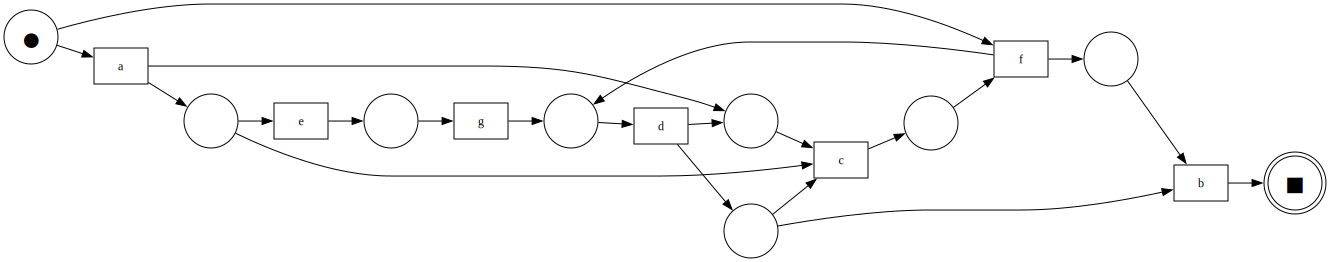

In [159]:
og_net, og_im, og_fm = alpha_miner.apply(og_event_log)
pm4py.visualization.petri_net.visualizer.apply(og_net, og_im, og_fm)

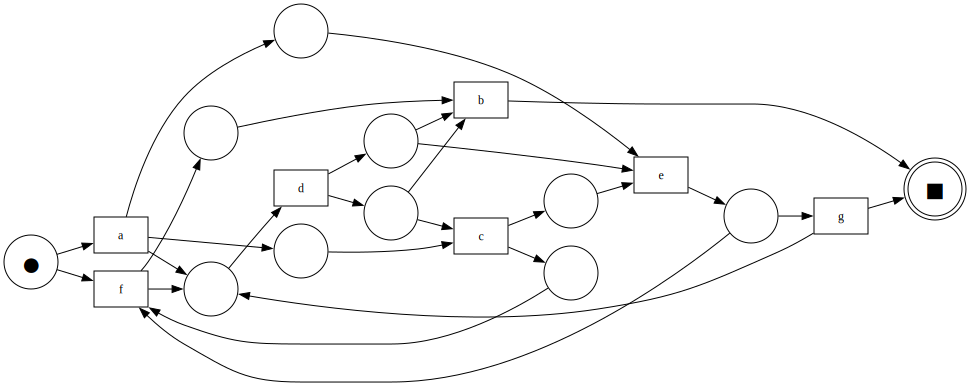

In [160]:
new_net, new_im, new_fm = alpha_miner.apply(new_event_log)
pm4py.visualization.petri_net.visualizer.apply(new_net, new_im, new_fm)

By visually comparing the two process models, we can see that there are differences in the structure of the models. Without going into too much detail, the model derived from the new logs appears to have additional paths that are not present in the original model.

In [161]:
def add_title_to_graphviz_source(source, title):
    source_code = source.source

    insertion_point = source_code.find('{') + 1
    new_source_code = (
        source_code[:insertion_point] +
        f'\n    label="{title}";\n    labelloc="t";\n    fontsize="20";\n' +
        source_code[insertion_point:]
    )

    source_titled = graphviz.Source(new_source_code)

    return source_titled

In [162]:
og_matrix = vis_footprints.visualizer.apply(og_footprints, 
                                            variant=pm4py.visualization.footprints.visualizer.Variants.SINGLE)
og_matrix_titled = add_title_to_graphviz_source(og_matrix, "Footprint Matrix of Model")

In [163]:
new_matrix = vis_footprints.visualizer.apply(new_footprints, 
                                             variant=pm4py.visualization.footprints.visualizer.Variants.SINGLE)
new_matrix_titled = add_title_to_graphviz_source(new_matrix, "Footprint Matrix of New Logs")

In [164]:
comp_matrix = vis_footprints.visualizer.apply(new_footprints, og_footprints, 
                                              variant=pm4py.visualization.footprints.visualizer.Variants.COMPARISON)
comp_matrix_titled = add_title_to_graphviz_source(comp_matrix, "Comparison of Footprint Matrices")

In [165]:
svg1 = og_matrix_titled.pipe(format='svg').decode('utf-8')
svg2 = new_matrix_titled.pipe(format='svg').decode('utf-8')
svg3 = comp_matrix_titled.pipe(format='svg').decode('utf-8')
html_code = f"""
<div style="display: flex; justify-content: center; align-items: flex-start;">
    <div style="margin: 10px;">{svg1}</div>
    <div style="margin: 10px;">{svg2}</div>
    <div style="margin: 10px;">{svg3}</div>
</div>
"""

display(HTML(html_code))

Comparing the two footprint matrices, we can observe some difference. For instance, the parallel relation (||) between activities c and g are not present in the footprint of the new logs.

## Token-based Replay

In [166]:
tbr_result = tokenreplay_algo.apply(new_event_log, og_net, og_im, og_fm)


replaying log with TBR, completed traces :: 100%|██████████| 6/6 [00:00<00:00, 3418.81it/s]


In [167]:
def tbr_result_to_df(tbr_result):
    trace = []
    fitness = []
    missing = []
    remaining = []

    for i, result in enumerate(tbr_result):
        trace.append(i+1)
        fitness.append(result['trace_fitness'])
        missing.append(result['missing_tokens'])
        remaining.append(result['remaining_tokens'])

    df = pd.DataFrame({
        'Trace': trace,
        'Fitness': fitness,
        'Missing Tokens': missing,
        'Remaining Tokens': remaining
    })
    return df

In [168]:
tbr_result_df = tbr_result_to_df(tbr_result)
tbr_result_df

,Trace,Fitness,Missing Tokens,Remaining Tokens
0,1,0.514286,2,4
1,2,0.844444,2,1
2,3,0.707071,4,2
3,4,0.675000,2,1
4,5,0.784091,3,2
5,6,0.763636,3,2


In [169]:
tbr_result_df[['Fitness', 'Missing Tokens', 'Remaining Tokens']].mean()

Fitness             0.714755
Missing Tokens      2.666667
Remaining Tokens    2.000000
dtype: float64

In [170]:
replay_visualization = pn_visualizer.apply(og_net, og_im, og_fm, 
                                           variant=pn_visualizer.Variants.FREQUENCY, 
                                           log=new_event_log)


replaying log with TBR, completed traces :: 100%|██████████| 6/6 [00:00<00:00, 1838.80it/s]


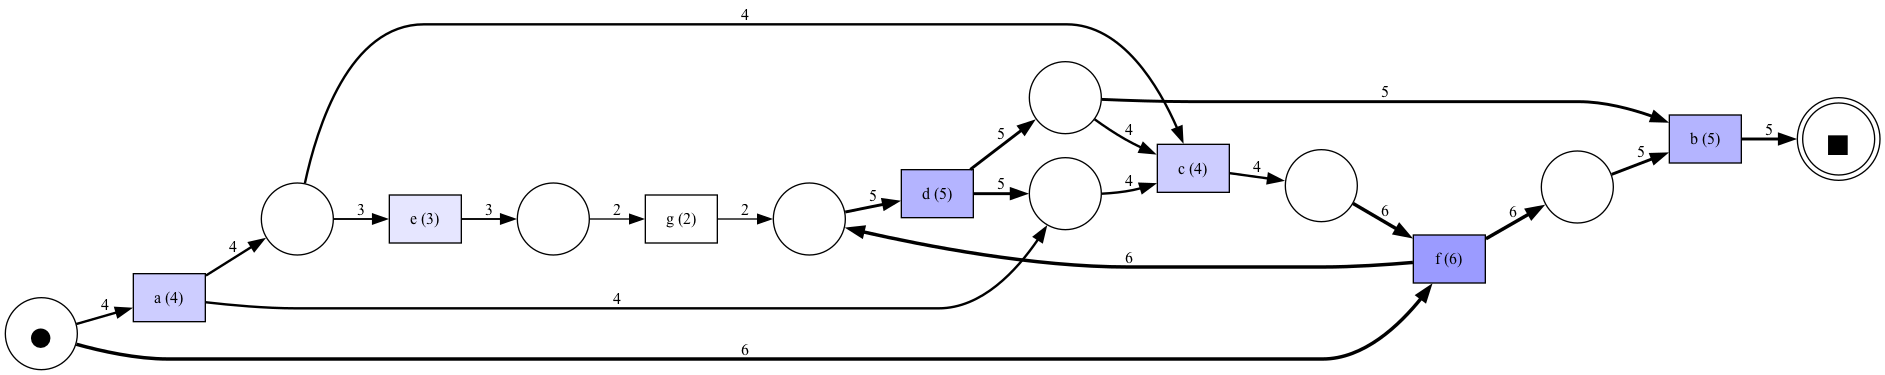

In [171]:
pm4py.visualization.petri_net.visualizer.view(replay_visualization)

### Interpretation of Results

The average replay fitness across all traces is approximately 0.71, indicating that the new logs have a moderate level of conformance to the original model. The best trace, is trace 2, with a fitness of 0.84, while the worst trace, is trace 1, with a fitness of 0.51.